## Import relevant libraries


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Read  data of 3592 UFC fights with 160 features describing fighter physical attributes and records before each bout  

In [23]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_01160a78b7aa42cb98a82a5e384d9ba4 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='OV9rOube-9Bn4QGSCRkecy3MdKh6NnmWXyoq_AeyYMy8',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_01160a78b7aa42cb98a82a5e384d9ba4.get_object(Bucket='ufcfightsoutcomeprediction-donotdelete-pr-obx20pvukizkhp',Key='ufc_data2.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Winner,title_bout,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,...,weight_class_Women's Strawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Sideways,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,Red,True,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,...,0,0,1,0,0,0,0,1,0,0
1,Red,True,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,...,0,0,1,0,0,0,0,0,1,0
2,Red,False,3,0.0,3.0,0.0,15.354839,11.322581,6.741935,4.387097,...,0,0,1,0,0,0,0,1,0,0
3,Blue,False,3,0.0,4.0,0.0,17.000000,14.000000,13.750000,11.000000,...,0,0,0,0,0,1,0,1,0,0
4,Blue,False,3,0.0,1.0,0.0,17.000000,14.500000,2.500000,2.000000,...,0,0,0,0,1,0,0,0,1,0


## Creater a binnary column for red (corner) fighter to be used as target label (winner (1) or loser (0))

In [24]:
winner_bn = np.zeros(len(df.Winner))
idx_red = np.where(df.Winner == 'Red')
idx_red = np.asarray(idx_red)
idx_red = np.squeeze(idx_red)
winner_bn[idx_red] = 1
print(winner_bn[0:5])

[1. 1. 1. 0. 0.]


## Initial analysis: Evaluate general features of winning fighters

In [25]:
ratio_red = df.R_wins/df.R_losses
ratio_red = np.where(ratio_red == float('inf'), 1, ratio_red) 
ratio_blue = df.B_wins/df.B_losses
ratio_blue = np.where(ratio_blue == float('inf'), 1, ratio_blue) 
ratio = np.zeros(len(df.Winner))
reach = np.zeros(len(df.Winner))
age = np.zeros(len(df.Winner))
weight = np.zeros(len(df.Winner))
height = np.zeros(len(df.Winner))
streak = np.zeros(len(df.Winner))
strikes = np.zeros(len(df.Winner))
corner = np.zeros(len(df.Winner))
takedowns = np.zeros(len(df.Winner))
for n in range(len(df.Winner)):
    if df.Winner[n] == 'Red':
        reach[n] =  df.R_Reach_cms[n] - df.B_Reach_cms[n]
        age[n] =  df.R_age[n] - df.B_age[n]
        weight[n] =  df.R_Weight_lbs[n] - df.B_Weight_lbs[n]
        height[n] =  df.R_Height_cms[n] - df.B_Height_cms[n]
        streak[n] = df.R_current_win_streak[n] - df.B_current_win_streak[n]
        strikes[n] = df.R_avg_TOTAL_STR_landed[n] - df.B_avg_TOTAL_STR_landed[n]
        ratio[n] = ratio_red[n] - ratio_blue[n] 
        takedowns[n] = df.R_avg_TD_landed[n] - df.B_avg_TD_landed[n]
        corner[n] = 1
        reach[n] =  df.B_Reach_cms[n] - df.R_Reach_cms[n]
    elif df.Winner[n] == 'Blue':
        age[n] =  df.B_age[n] - df.R_age[n]
        weight[n] =  df.B_Weight_lbs[n] - df.R_Weight_lbs[n]
        height[n] =  df.B_Height_cms[n] - df.R_Height_cms[n]
        streak[n] = df.B_current_win_streak[n] - df.R_current_win_streak[n]
        strikes[n] = df.B_avg_TOTAL_STR_landed[n] - df.R_avg_TOTAL_STR_landed[n]
        ratio[n] = ratio_blue[n] - ratio_red[n]
        corner[n] = 0
        takedowns[n] = df.R_avg_TD_landed[n] - df.B_avg_TD_landed[n]

## Normalize features for comparison (subract mean and divide by standard deviation)

In [26]:
age_norm = (age - np.nanmean(age)) / np.nanstd(age)
height_norm = (height - np.nanmean(height)) / np.nanstd(height)
weight_norm = (weight - np.nanmean(weight)) / np.nanstd(weight)
reach_norm = (reach - np.nanmean(reach)) / np.nanstd(reach)
streak_norm = (streak - np.nanmean(streak)) / np.nanstd(streak)
takedowns_norm = (takedowns - np.nanmean(takedowns)) / np.nanstd(takedowns)
strikes_norm = (strikes - np.nanmean(strikes)) / np.nanstd(strikes)

## Produce boxplot to evaluate features of winning fighters

([<matplotlib.axis.XTick at 0x7f14ad979e10>,
 <a list of 7 Text xticklabel objects>)

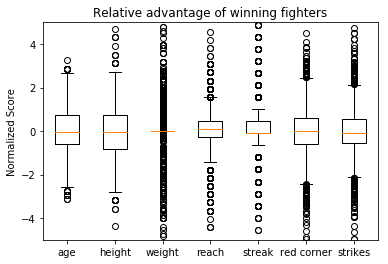

In [27]:
data_for_boxplot = np.stack((age_norm,height_norm,weight_norm,reach_norm,streak_norm,strikes_norm,takedowns_norm),1)
plt.boxplot(data_for_boxplot)
axes = plt.gca()
axes.set_ylim([-5,5])
plt.ylabel('Normalized Score')
plt.title('Relative advantage of winning fighters')
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['age', 'height', 'weight', 'reach', 'streak','red corner','strikes','take downs'])

## No clear difference is observed. A secondary visual analysis is carried out evaluating whether the simple presence of a difference (advantage) can determine the winning fighter

In [28]:
ratio_bn = np.zeros(len(df.Winner))
reach_bn = np.zeros(len(df.Winner))
age_bn = np.zeros(len(df.Winner))
height_bn = np.zeros(len(df.Winner))
weight_bn = np.zeros(len(df.Winner))
streak_bn = np.zeros(len(df.Winner))
strikes_bn = np.zeros(len(df.Winner))
takedowns_bn = np.zeros(len(df.Winner))
for n in range(len(df.Winner)):
    if reach[n] > 0:
        reach_bn[n] = 1
    elif reach[n] < 0:
        reach_bn[n] = -1
    if age[n] > 0:
        age_bn[n] = 1
    elif age[n] < 0:
        age_bn[n] = -1
    if streak[n] > 0:
        streak_bn[n] = 1
    elif streak[n] < 0:
        streak_bn[n] = -1
    if strikes[n] > 0:
       strikes_bn[n] = 1
    elif strikes[n] < 0:
        strikes_bn[n] = -1       
    if ratio[n] > 0:
       ratio_bn[n] = 1
    elif ratio[n] < 0:
        ratio_bn[n] = -1
    if height[n] > 0:
       height_bn[n] = 1
    elif height[n] < 0:
        height_bn[n] = -1              
    if weight[n] > 0:
       weight_bn[n] = 1
    elif weight[n] < 0:
        weight_bn[n] = -1      
    if takedowns[n] > 0:
       takedowns_bn[n] = 1
    elif takedowns[n] < 0:
        takedowns_bn[n] = -1 

## Calculate the number of times the advantage is positve or negative (e.g., how many times was the winning fighter older/younger than his opponent )

In [29]:
reach_pos = np.where(reach_bn == 1)
reach_pos = np.asarray(reach_pos)
reach_pos = reach_pos.size
reach_neg = np.where(reach_bn == -1)
reach_neg = np.asarray(reach_neg)
reach_neg = reach_neg.size

age_pos = np.where(age_bn == 1)
age_pos = np.asarray(age_pos)
age_pos = age_pos.size
age_neg = np.where(age_bn == -1)
age_neg = np.asarray(age_neg)
age_neg = age_neg.size

height_pos = np.where(height_bn == 1)
height_pos = np.asarray(height_pos)
height_pos = height_pos.size
height_neg = np.where(height_bn == -1)
height_neg = np.asarray(height_neg)
height_neg = height_neg.size

weight_pos = np.where(weight_bn == 1)
weight_pos = np.asarray(weight_pos)
weight_pos = weight_pos.size
weight_neg = np.where(weight_bn == -1)
weight_neg = np.asarray(weight_neg)
weight_neg = weight_neg.size

streak_pos = np.where(streak_bn == 1)
streak_pos = np.asarray(streak_pos)
streak_pos = streak_pos.size
streak_neg = np.where(streak_bn == -1)
streak_neg = np.asarray(streak_neg)
streak_neg = streak_neg.size

strikes_pos = np.where(strikes_bn == 1)
strikes_pos = np.asarray(strikes_pos)
strikes_pos = strikes_pos.size
strikes_neg = np.where(strikes_bn == -1)
strikes_neg = np.asarray(strikes_neg)
strikes_neg = strikes_neg.size

ratio_pos = np.where(ratio_bn == 1)
ratio_pos = np.asarray(ratio_pos)
ratio_pos = ratio_pos.size
ratio_neg = np.where(ratio_bn == -1)
ratio_neg = np.asarray(ratio_neg)
ratio_neg = ratio_neg.size

corner_pos = np.where(corner == 1)
corner_pos = np.asarray(corner_pos)
corner_pos = corner_pos.size
corner_neg = corner.size - corner_pos
corner_neg = np.where(corner == 0)
corner_neg = np.asarray(corner_neg)
corner_neg = corner_neg.size

takedowns_pos = np.where(takedowns == 1)
takedowns_pos = np.asarray(takedowns_pos)
takedowns_pos = takedowns_pos.size
takedowns_neg = takedowns.size - takedowns_pos
takedowns_neg = np.where(takedowns == 0)
takedowns_neg = np.asarray(takedowns_neg)
takedowns_neg = takedowns_neg.size

pos = (reach_pos/reach_bn.size, age_pos/age_bn.size, streak_pos/streak_bn.size, \
       strikes_pos/strikes_bn.size, ratio_pos/ratio_bn.size, corner_pos/corner.size, weight_pos/weight_bn.size, height_pos/height_bn.size, \
       takedowns_pos/takedowns_bn.size)
neg = (reach_neg/reach_bn.size, age_neg/age_bn.size, streak_neg/streak_bn.size, \
       strikes_neg/strikes_bn.size, ratio_neg/ratio_bn.size, corner_neg/corner.size, weight_neg/weight_bn.size, height_neg/height_bn.size, \
       takedowns_neg/takedowns_bn.size)

## Make a bar plot showing positive or negative differences 

Text(0.5, 1.0, 'Metrics of winner')

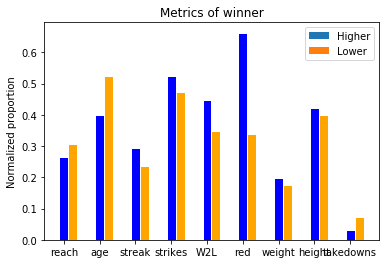

In [30]:
ind = np.arange(9)
barWidth = 0.25
r1 = np.arange(len(ind)); plt.bar(r1, pos, color='blue',width=barWidth, edgecolor='white')
r2 = [x + barWidth for x in r1]; plt.bar(r2, neg, color='orange',width=barWidth, edgecolor='white')
plt.xticks(ind, ('reach', 'age', 'streak', 'strikes', 'W2L','red','weight','height','takedowns'))
plt.legend((p1[0], p2[0]), ('Higher', 'Lower'))
plt.ylabel('Normalized proportion')
plt.title('Metrics of winner')

## The plot above shows that > 60% of winning fighters are assigned the red corner (normally reserved to highest ranked fighter). Age (older/younger) and the difference between the Win:Lose ratio (W2L) also seem to be important factors indicating the most likely fighter in a UFC bout

Text(0.5, 1.0, 'Factors sorted by potential impact in determining the winner')

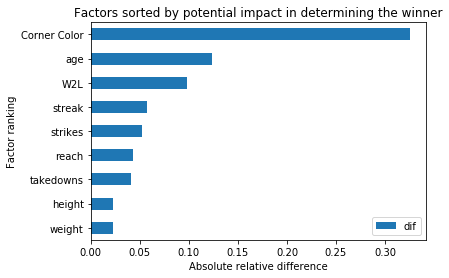

In [31]:
pos = np.asarray(pos)
neg = np.asarray(neg)
dif = np.abs(pos - neg)
features = ['reach', 'age', 'streak', 'strikes', 'W2L','Corner Color','weight','height','takedowns']
pre_df2 = np.stack((dif, features),1)
pre_df2 = pd.DataFrame(pre_df2,columns = ['dif','features'])
df2 = pre_df2.sort_values(by=['dif'])
df2['dif'] = df2['dif'].astype(float)
df2.plot.barh(x='features', y='dif')
plt.xlabel('Absolute relative difference')
plt.ylabel('Factor ranking')
plt.title('Factors sorted by potential impact in determining the winner')

## Apart from the corner color, age, the W2L ratio, and the present winning streak of seem to be the best indicators among the analyzed features in determining the outcome of a fight  

## In order the predict a fight outcome, this analysis is approached as a clasification problem: A logistic regression model was fitted using features "age",  "W2L", and "streak". The model evaluates wheather the fighter of the red corner will win (1) or lose (0), based on the calculated difference in the features above, between the red and blue fighters

## Logistic regression

In [32]:
# Store relevant features in a new data frame
pre_data_frame = np.stack((age,ratio,streak,winner_bn),axis = 1)
df2 = pd.DataFrame(pre_data_frame,columns = ['Age','W2L','Streak','Winner'])
feature_cols = ['Age','W2L','Streak']

X = df2[feature_cols] # Features
y = df2.Winner # Target variable

#Here, the Dataset is broken into two parts in a ratio of 75:25. It means 75% data will be used for model training and 25% for model testing.
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0) 

# instantiate the model (using the default parameters)
logreg = LogisticRegression()    

# fit the model with data
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

# Output confussion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[  8, 317],
       [ 20, 553]])

Accuracy: 0.6247216035634744


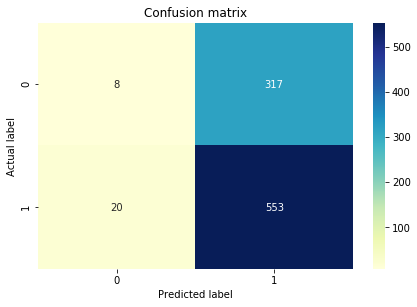

In [33]:
import seaborn as sns
class_names=[0,1] # name  of classes
#fig, ax = plt.subplots()
#tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names)
#plt.yticks(tick_marks, class_names)
class_names=[0,1] # name  of classes
#fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
#plt.xticks(tick_marks, class_names)
#plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

## The model shows an accuracy of 62 %. However, the probability of the red corner fighter winning is higher than it is of it loosing. The red corner is assigned to the fighter with highest ranking. The ranking summarizes a large amount information from human "experts". Hence, it is not entirely surprising that the color assigned to a fighter has a high predictive power.

## As a consequence, the dataset is biased. A potential way to improve the prediction can be altering the probability threshold assigned to winning (1) or losing (0). Since a red corner fighter has inherently a higher chance of winning, one could assign a prediction as positive with a probability outcome < 50 %. 

## This sensitivity experiment is conducted below

In [34]:
# Compare different detection thresholds of probability       
prob = logreg.predict_proba(X_test)
tholds = np.arange(0.1, 0.9, 0.05)       
y_pred2 = np.zeros((len(y_pred),len(tholds)))       
for ii in range(len(tholds)):
    thold = tholds[ii]
    for n in range(len(prob)):
        if prob[n,0] >= thold:
           y_pred2[n,ii] = 0
        elif prob[n,0] < thold:
           y_pred2[n,ii] = 1 

accuracies = np.zeros(len(tholds))
precisions = np.zeros(len(tholds))
recalls = np.zeros(len(tholds))
f1s = np.zeros(len(tholds))
for n in range(len(tholds)):
    accuracies[n] = metrics.accuracy_score(y_test, y_pred2[:,n])
    precisions[n] = metrics.precision_score(y_test, y_pred2[:,n])
    recalls[n] = metrics.recall_score(y_test, y_pred2[:,n])
    f1s[n] = metrics.f1_score(y_test, y_pred2[:,n])

## Plot model metrics as a function of the probability threshold 

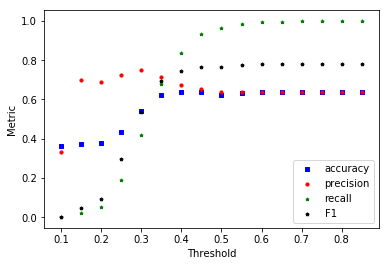

In [35]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(tholds, accuracies, s=10, c='b', marker="s", label='accuracy')
ax1.scatter(tholds,precisions, s=10, c='r', marker="o", label='precision')
ax1.scatter(tholds,recalls, s=10, c='g', marker="*", label='recall')
ax1.scatter(tholds,f1s, s=10, c='k', marker="p", label='F1')
plt.legend(loc='lower right');
plt.xlabel('Threshold')   
plt.ylabel('Metric') 
plt.show()